In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pandas as pd
import math
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils as utils

# CNN Implementation

### Import MNIST dataset

In [2]:
MNIST_train = datasets.MNIST(root="./dataset/", train=True,
    transform=transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor()
    ]), download=True)
MNIST_test = datasets.MNIST(root="./dataset/", train=False,
    transform=transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor()
    ]), download=False) 

MNIST_train = utils.data.Subset(MNIST_train, range(6000))
MNIST_test = utils.data.Subset(MNIST_test, range(6000))
MNIST_trainloader = utils.data.DataLoader(MNIST_train, batch_size=100, shuffle=True, num_workers=4)
MNIST_testloader = utils.data.DataLoader(MNIST_test, batch_size=100, shuffle=True, num_workers=4)

### Implement and train a VGG11 net on the MNIST dataset

In [3]:
class NN(nn.Module):

    def __init__(self):
        super(NN, self).__init__()

        self.architecture = nn.Sequential()
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.architecture(x)
    
    def update_param(self, archi, optimizer=None):
        self.architecture = archi
        if optimizer == "rms":
            self.optimize = torch.optim.RMSprop(self.parameters(), lr=0.01, momentum=0.9)
        elif optimizer == "adam":
            self.optimize = torch.optim.Adam(self.parameters(), lr=0.01)
        else:
            self.optimize = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
    
    def train_model(self, loader):
        total_loss, total_accurate = 0.0, 0
        n = len(loader.dataset)
        self.train()
        for feature, label in loader:
            feature, label = feature.to('cpu'), label.to('cpu')
            self.optimize.zero_grad()
            hat = self(feature)

            loss = self.loss(hat, label)
            loss.backward()
            self.optimize.step()

            total_loss += loss.item()
            total_accurate += np.sum(np.argmax(hat.detach().numpy(), axis=1) == label.detach().numpy())
        return total_loss / n, total_accurate / n
    
    def test_model(self, loader):
        total_loss, total_accurate = 0.0, 0
        n = len(loader.dataset)
        self.eval()
        with torch.no_grad():
            for feature, label in loader:
                feature, label = feature.to('cpu'), label.to('cpu')
                hat = self(feature)
                total_loss += self.loss(hat, label).item()
                total_accurate += np.sum(np.argmax(hat.detach().numpy(), axis=1) == label.detach().numpy())
        return total_loss / n, total_accurate / n
    

    def model(self, train_loader, test_loader=None, num_epoch=20):
        train_loss, train_accuracy, test_loss, test_accuracy = [], [], [], []
        for _ in range(num_epoch):
            loss, accuracy = self.train_model(train_loader)
            train_loss.append(loss)
            train_accuracy.append(accuracy)
            if test_loader:
                loss, accuracy = self.test_model(test_loader)
                test_loss.append(loss)
                test_accuracy.append(accuracy)
        return train_loss, train_accuracy, test_loss, test_accuracy

### Show results in plots

In [4]:
net = NN()
architec = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2), 
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(512, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
net.update_param(archi=architec)
trl, tra, tl, ta = net.model(MNIST_trainloader, MNIST_testloader, num_epoch=15)
epoch_15 = range(1,16)

Text(0, 0.5, 'traning loss')

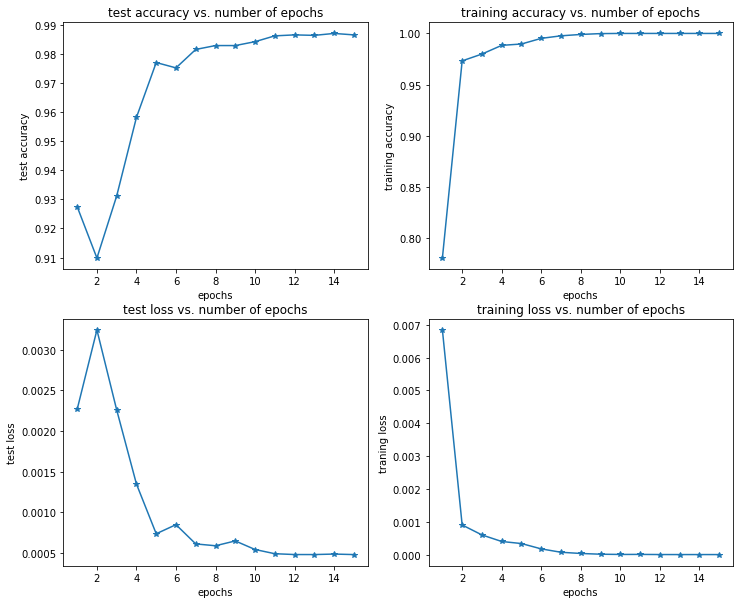

In [5]:
_, [(a1,a2),(a3,a4)] = plt.subplots(2,2, figsize=(12,10))
a1.plot(epoch_15, ta, '*-')
a1.set_title("test accuracy vs. number of epochs")
a1.set_xlabel("epochs")
a1.set_ylabel("test accuracy")

a2.plot(epoch_15, tra, '*-')
a2.set_title("training accuracy vs. number of epochs")
a2.set_xlabel("epochs")
a2.set_ylabel("training accuracy")

a3.plot(epoch_15, tl, '*-')
a3.set_title("test loss vs. number of epochs")
a3.set_xlabel("epochs")
a3.set_ylabel("test loss")

a4.plot(epoch_15, trl, '*-')
a4.set_title("training loss vs. number of epochs")
a4.set_xlabel("epochs")
a4.set_ylabel("traning loss")

## Flip and blur the test set images

### test accuracy vs. type of flip

In [6]:
vertical_test = datasets.MNIST(root="./dataset/", train=False,
    transform=transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        transforms.RandomVerticalFlip(p=1)
    ]), download=False) 
vertical_test = utils.data.Subset(vertical_test, range(6000))
vertical_testloader = utils.data.DataLoader(vertical_test, batch_size=100, shuffle=True, num_workers=4)

horizontal_test = datasets.MNIST(root="./dataset/", train=False,
    transform=transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=1)
    ]), download=False) 
horizontal_test = utils.data.Subset(horizontal_test, range(6000))
horizontal_testloader = utils.data.DataLoader(horizontal_test, batch_size=100, shuffle=True, num_workers=4)

In [7]:
_, vertical_accuracy = net.test_model(vertical_testloader)
print(f"The test accuracy for flipping the image left to right is {vertical_accuracy:.4f}.")

_, horizontal_accuracy = net.test_model(horizontal_testloader)
print(f"The test accuracy for flipping the image top to bottom is {horizontal_accuracy:.4f}.")

The test accuracy for flipping the image left to right is 0.4208.
The test accuracy for flipping the image top to bottom is 0.4737.


### test accuracy vs. Gaussian noise

In [8]:
variance = [0.01, 0.1, 1]
gaussian_accuracy = []
for v in variance:
    gaussian = lambda x: x + math.sqrt(v) * torch.randn_like(x)
    test = datasets.MNIST(root="./dataset/", train=False,
        transform=transforms.Compose([
            transforms.Resize([32, 32]),
            transforms.ToTensor(),
            transforms.Lambda(gaussian)
        ])) 
    test = utils.data.Subset(test, range(6000))
    testloader = utils.data.DataLoader(test, batch_size=100, shuffle=True)
    _, a = net.test_model(testloader)
    gaussian_accuracy.append(f"{a:.5f}")

In [9]:
report = pd.DataFrame(data={"variance": variance, "accuracy": gaussian_accuracy})
print(report.to_string(index=False))

 variance accuracy
     0.01  0.97467
     0.10  0.11183
     1.00  0.09783


## Verify the effect of regularization.

In [10]:
aug_MNIST_train = datasets.MNIST(root="./dataset/", train=True,
    transform=transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor()
    ]), download=True)
aug_MNIST_train = utils.data.Subset(aug_MNIST_train, range(1500))
aug_vertical_train = datasets.MNIST(root="./dataset/", train=True,
    transform=transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        transforms.RandomVerticalFlip(p=1)
    ]), download=True) 
aug_vertical_train = utils.data.Subset(aug_vertical_train, range(1500))
aug_horizontal_train = datasets.MNIST(root="./dataset/", train=False,
    transform=transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=1)
    ]), download=True)
aug_horizontal_train = utils.data.Subset(aug_horizontal_train, range(1500))
gaussian_001 = lambda x: x + math.sqrt(0.01) * torch.randn_like(x)
aug_gaussian_train = datasets.MNIST(root="./dataset/", train=False,
        transform=transforms.Compose([
            transforms.Resize([32, 32]),
            transforms.ToTensor(),
            transforms.Lambda(gaussian_001)
        ]), download=True)
aug_gaussian_train = utils.data.Subset(aug_gaussian_train, range(1500))

aug_train = utils.data.ConcatDataset([aug_MNIST_train, aug_vertical_train,
                                      aug_horizontal_train, aug_gaussian_train])
aug_trainloader = utils.data.DataLoader(aug_train, batch_size=100, shuffle=True)
aug_net = NN()
aug_net.update_param(archi=architec)
aug_trl, aug_tra, _, _ = aug_net.model(aug_trainloader)

In [11]:
epoch_20 = range(1, 21)
report = pd.DataFrame(data={
    "epoch": epoch_20,
    "training loss": ["{:.5f}".format(x) for x in aug_trl],
    "training accuracy": ["{:.5f}".format(x) for x in aug_tra]
})
print(report.to_string(index=False))

 epoch training loss training accuracy
     1       0.00552           0.84383
     2       0.00179           0.94000
     3       0.00111           0.96483
     4       0.00079           0.97433
     5       0.00049           0.98367
     6       0.00039           0.98667
     7       0.00025           0.99233
     8       0.00062           0.97983
     9       0.00025           0.99217
    10       0.00015           0.99633
    11       0.00008           0.99750
    12       0.00008           0.99733
    13       0.00010           0.99717
    14       0.00015           0.99567
    15       0.00004           0.99867
    16       0.00007           0.99817
    17       0.00001           0.99983
    18       0.00002           0.99950
    19       0.00002           0.99933
    20       0.00002           0.99967


In [12]:
_, vertical_accuracy = aug_net.test_model(vertical_testloader)
print(f"The test accuracy for flipping the image left to right is {vertical_accuracy:.4f}.")

_, horizontal_accuracy = aug_net.test_model(horizontal_testloader)
print(f"The test accuracy for flipping the image top to bottom is {horizontal_accuracy:.4f}.")

The test accuracy for flipping the image left to right is 0.9410.
The test accuracy for flipping the image top to bottom is 0.9663.


In [13]:
gaussian_accuracy = []
for v in variance:
    test = datasets.MNIST(root="./dataset/", train=False,
        transform=transforms.Compose([
            transforms.Resize([32, 32]),
            transforms.ToTensor(),
            transforms.Lambda(gaussian)
        ])) 
    test = utils.data.Subset(test, range(6000))
    testloader = utils.data.DataLoader(test, batch_size=100, shuffle=True)
    _, a = aug_net.test_model(testloader)
    gaussian_accuracy.append(f"{a:.5f}")

In [14]:
report = pd.DataFrame(data={"variance": variance, "accuracy": gaussian_accuracy})
print(report.to_string(index=False))

 variance accuracy
     0.01  0.97967
     0.10  0.87583
     1.00  0.13050


The train data augmentation is with the original image, vertical flip, horizontal flip, and the Gaussian noise with variance 0.01. We can see that with data augmentation, the test accuracy for flipping the image is much better than in previous part, and the test accuracy for Gaussian noice increases.

## Train the CNN with RMSprop and Adam

In [15]:
rmsprop_net = NN()
rmsprop_net.update_param(archi=architec, optimizer="rms")
_, rmsprop_tra, _, rmsprop_ta = rmsprop_net.model(MNIST_trainloader, MNIST_testloader)

In [16]:
adam_net = NN()
adam_net.update_param(archi=architec, optimizer="adam")
_, adam_tra, _, adam_ta = adam_net.model(MNIST_trainloader, MNIST_testloader)

Text(0, 0.5, 'train accuracy')

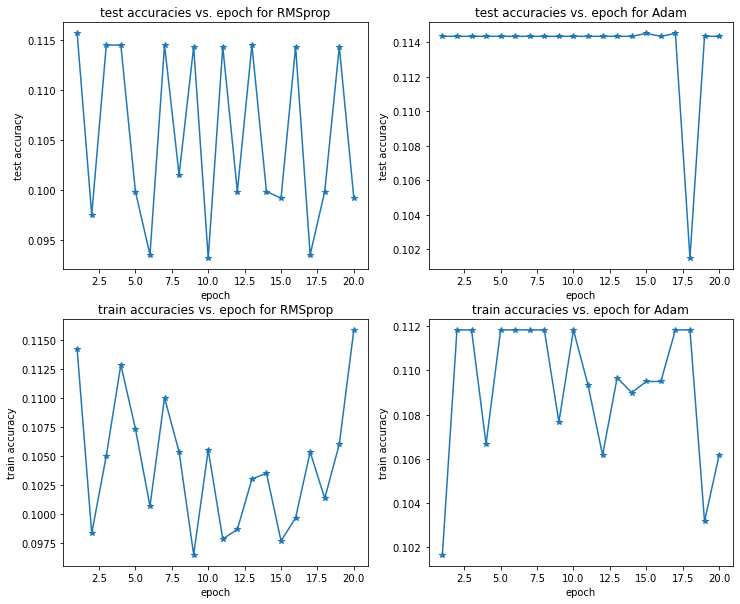

In [17]:
_, [(a1,a2),(a3,a4)] = plt.subplots(2,2, figsize=(12,10))
a1.plot(epoch_20, rmsprop_ta, '*-')
a1.set_title("test accuracies vs. epoch for RMSprop")
a1.set_xlabel("epoch")
a1.set_ylabel("test accuracy")

a3.plot(epoch_20, rmsprop_tra, '*-')
a3.set_title("train accuracies vs. epoch for RMSprop")
a3.set_xlabel("epoch")
a3.set_ylabel("train accuracy")

a2.plot(epoch_20, adam_ta, '*-')
a2.set_title("test accuracies vs. epoch for Adam")
a2.set_xlabel("epoch")
a2.set_ylabel("test accuracy")

a4.plot(epoch_20, adam_tra, '*-')
a4.set_title("train accuracies vs. epoch for Adam")
a4.set_xlabel("epoch")
a4.set_ylabel("train accuracy")

We can see that both optimizers have similar test accuracy and training accuracy, which are both pretty low compared to what SGD gives originally. Therefore, SGD is preferred, not only because it has a higher accuracy, but also its accuracy and loss function converges. From the above plot, it is clear that RMSprop and Adam fluctuate and does not converge.

## Replace ReLU with Sigmoid

In [18]:
sigmoid_architec = nn.Sequential(
                        nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.Sigmoid(), nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.Sigmoid(), nn.MaxPool2d(2, 2), 
                        nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.Sigmoid(),
                        nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.Sigmoid(), nn.MaxPool2d(2, 2),
                        nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.Sigmoid(),
                        nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.Sigmoid(), nn.MaxPool2d(2, 2),
                        nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.Sigmoid(),
                        nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.Sigmoid(), nn.MaxPool2d(2, 2),
                        nn.Flatten(),
                        nn.Linear(512, 4096), nn.Sigmoid(), nn.Dropout(0.5),
                        nn.Linear(4096, 4096), nn.Sigmoid(), nn.Dropout(0.5),
                        nn.Linear(4096, 10)
                    )

sigmoid_net = NN()
sigmoid_net.update_param(archi=sigmoid_architec)
_, sigmoid_tra, _, sigmoid_ta = sigmoid_net.model(MNIST_trainloader, MNIST_testloader)

Text(0, 0.5, 'train accuracy')

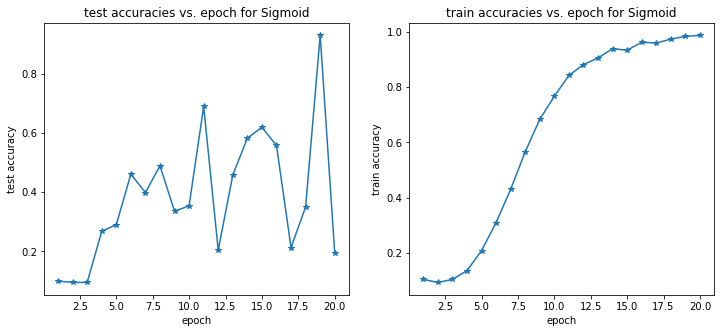

In [19]:
_, (a1,a2) = plt.subplots(1,2, figsize=(12,5))
a1.plot(epoch_20, sigmoid_ta, '*-')
a1.set_title("test accuracies vs. epoch for Sigmoid")
a1.set_xlabel("epoch")
a1.set_ylabel("test accuracy")

a2.plot(epoch_20, sigmoid_tra, '*-')
a2.set_title("train accuracies vs. epoch for Sigmoid")
a2.set_xlabel("epoch")
a2.set_ylabel("train accuracy")

ReLU performs much better than Sigmoid, since with ReLU, our test accuracy converges towards 100% at the end, while Sigmoid flucutates in the testing acccuracy and is generally lower than ReLU. This is because ReLU's gradient is less likely to vanish compared to Sigmoid, whose gradient is smaller as the absolute value of $x$ increases.

## Remove Dropout

In [20]:
removeDrop_architec = nn.Sequential(
                        nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2), 
                        nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
                        nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2),
                        nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
                        nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2, 2),
                        nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
                        nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2, 2),
                        nn.Flatten(),
                        nn.Linear(512, 4096), nn.ReLU(),
                        nn.Linear(4096, 4096), nn.ReLU(),
                        nn.Linear(4096, 10)
                    )

removeDrop_net = NN()
removeDrop_net.update_param(archi=removeDrop_architec)
_, removeDrop_tra, _, removeDrop_ta = removeDrop_net.model(MNIST_trainloader, MNIST_testloader)

Text(0, 0.5, 'train accuracy')

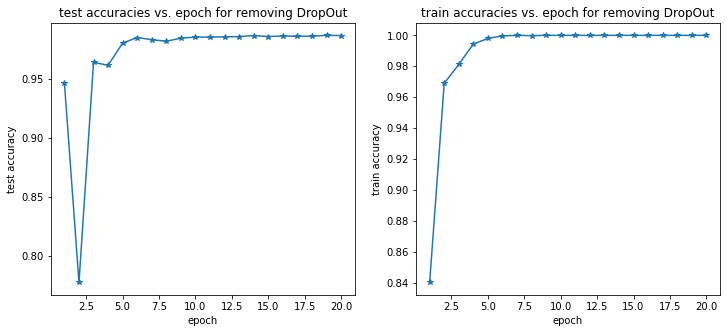

In [21]:
_, (a1,a2) = plt.subplots(1,2, figsize=(12,5))
a1.plot(epoch_20, removeDrop_ta, '*-')
a1.set_title("test accuracies vs. epoch for removing DropOut")
a1.set_xlabel("epoch")
a1.set_ylabel("test accuracy")

a2.plot(epoch_20, removeDrop_tra, '*-')
a2.set_title("train accuracies vs. epoch for removing DropOut")
a2.set_xlabel("epoch")
a2.set_ylabel("train accuracy")

After removing dropout, the CNN converges more quickly than original one.
